# Quality Metrics and Reconstruction Demo

Demonstrate the use of full reference metrics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.exposure import adjust_gamma, rescale_intensity
from xdesign import *


def rescale(reconstruction, hi):
    I = rescale_intensity(reconstruction, out_range=(0., 1.))
    return adjust_gamma(I, 1, hi)

`polytope` failed to import `cvxopt.glpk`.
Will use `scipy.optimize.linprog`.


Generate a phantom.

In [2]:
np.random.seed(0)
soil_like_phantom = Soil()

/home/beams0/B242827/Documents/xdesign/xdesign/phantom.py:317: RuntimeWarning: Reached termination criteria of 200 attempts before adding all of the circles.
  kTERM_CRIT), RuntimeWarning)


Generate a figure showing the phantom and save the discrete conversion for later.

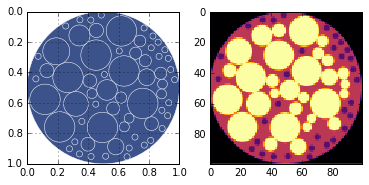

In [3]:
discrete = sidebyside(soil_like_phantom, 100)
plt.savefig('Soil_sidebyside.png', dpi='figure',
        orientation='landscape', papertype=None, format=None,
        transparent=True, bbox_inches='tight', pad_inches=0.0,
        frameon=False)
plt.show()

Simulate data acquisition for parallel beam around 180 degrees.

In [4]:
sx, sy = 100, 100
step = 1. / sy
prb = Probe(Point([step / 2., -10]), Point([step / 2., 10]), step)
theta = np.pi / sx
sino = np.zeros(sx * sy)
a = 0
for m in range(sx):
    for n in range(sy):
        update_progress((m*sy + n)/(sx*sy))
        sino[a] = prb.measure(soil_like_phantom)
        a += 1
        prb.translate(step)
    prb.translate(-1)
    prb.rotate(theta, Point([0.5, 0.5]))
update_progress(1)

[##########] 100.00%


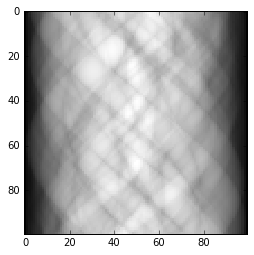

In [34]:
plt.imshow(np.reshape(sino, (sx, sy)), cmap='gray', interpolation='nearest')
# plt.hist(sino)
plt.show()

Reconstruct the phantom using 3 different techniques: ART, SIRT, and MLEM.

In [6]:
hi = 1  # highest expected value in reconstruction (for rescaling)
niter = 10  # number of iterations

init = 1e-12 * np.ones((sx, sy))
rec_art = art(prb, sino, init, niter)
rec_art = rescale(np.rot90(rec_art)[::-1], hi)

init = 1e-12 * np.ones((sx, sy))
rec_sirt = sirt(prb, sino, init, niter)
rec_sirt = rescale(np.rot90(rec_sirt)[::-1], hi)

init = 1e-12 * np.ones((sx, sy))
rec_mlem = mlem(prb, sino, init, niter)
rec_mlem = rescale(np.rot90(rec_mlem)[::-1], hi)

[##########] 100.00%
[##########] 100.00%
[##########] 100.00%


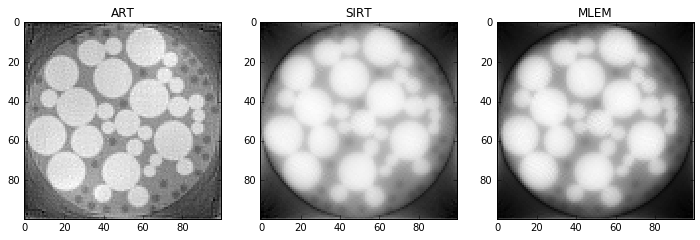

In [7]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(rec_art, cmap='gray', interpolation='none')
plt.title('ART')
plt.subplot(132)
plt.imshow(rec_sirt, cmap='gray', interpolation='none')
plt.title('SIRT')
plt.subplot(133)
plt.imshow(rec_mlem, cmap='gray', interpolation='none')
plt.title('MLEM')
plt.show()

Compute local quality for each reconstruction using MS-SSIM, a convolution based quality metric.

In [8]:
metrics = compute_quality(discrete, [rec_art, rec_sirt, rec_mlem], method="MSSSIM")

Plot the average quality at each level of detail for each reconstruction in a line plot. Then display the local quality map for each reconstruction to see why certain reconstructions are ranked higher than others.

In this case, it's clear that ART is ranking higer than MLEM and SIRT at smaller scales because the small dark particles are visible; whereas for SIRT and MLEM they are unresolved. We can also see that the large yellow circles have a more accurately rendered luminance for SIRT and MLEM which is what causes these methods to be ranked higher at larger scales.

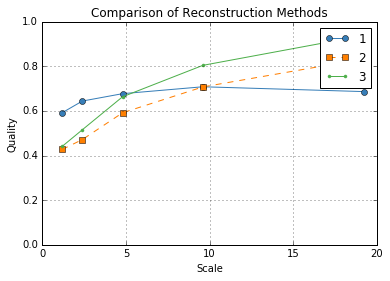

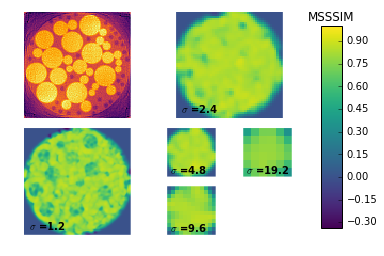

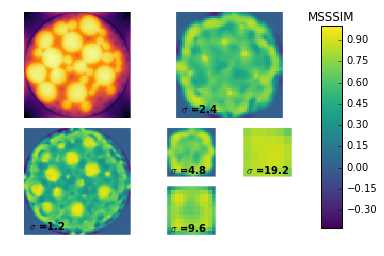

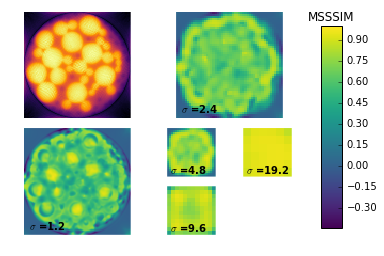

In [9]:
plot_metrics(metrics)
plt.show()

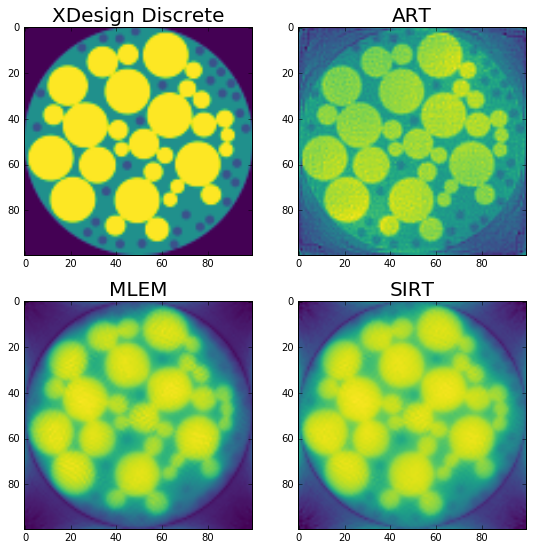

In [31]:
# Figure for TomoBank Poster
plt.figure(figsize=(9,9), dpi=600)
plt.subplot(2,2,1)
plt.imshow(discrete)
plt.title('XDesign Discrete', fontsize=20)
plt.subplot(2,2,2)
plt.imshow(rec_art)
plt.title('ART', fontsize=20)
plt.subplot(2,2,3)
plt.imshow(rec_mlem)
plt.title('MLEM', fontsize=20)
plt.subplot(2,2,4)
plt.imshow(rec_sirt)
plt.title('SIRT', fontsize=20)
plt.viridis()
plt.savefig('TomoBank_discrete.png', dpi='figure',
        orientation='landscape', papertype=None, format=None,
        transparent=True, bbox_inches='tight', pad_inches=0.0,
        frameon=False)
plt.show()